## Import Libraries

In [115]:
import pandas as pd
from cm_api import *
from helper_funct import *
from helper_funct1 import *
from cm_config import config
import matplotlib.pyplot as plt
from tabulate import tabulate 
import seaborn as sns
from scipy import stats

## Request API Token

In [2]:
api_token = get_api_token(config['refresh_token'])

## Collect Top 200 Spotify Weekly Charts (US) for 2020

### Create list of dates

In [3]:
date_list = get_date_range('2020-01-01', '2020-12-11', 'W')

In [4]:
first_date = date_list[0]
recent_date = date_list[-1]
len(date_list)

49

### Collect top tracks for 2020

In [5]:
counter = 0
spotify_chart_data = []
for date in date_list:
    data = get_spotify_charts(api_token, date, 'US', 'regional', 'weekly')
    counter += 1
    print(counter)
    for track in data:
        track_tuple = (track['added_at'],track['rank'], track['name'], track['cm_track'], track['artist_names'],
                      track['cm_artist'], track['current_plays'], track['time_on_chart'], track['velocity'])
        spotify_chart_data.append(track_tuple)

spotify2020 = pd.DataFrame(spotify_chart_data, columns=['add_date','rank', 'title', 'cm_track_id', 'artist_names', 'cm_artist_ids', 'current_plays', 'time_on_chart', 'velocity'])

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


### Save raw data

In [6]:
spotify2020.to_csv('spotify2020_raw.csv')

In [18]:
spotify2020.head()

,add_date,rank,title,cm_track_id,artist_names,cm_artist_ids,current_plays,time_on_chart,velocity,primary_artist,secondary_artist,primary_artist ID,secondfary_artist ID
0,2020-01-09T00:00:00.000Z,1,The Box,27599255,[Roddy Ricch],[839964],18952305,55,0.000000,Roddy Ricch,None,839964,NaN
1,2020-01-09T00:00:00.000Z,2,ROXANNE,27228348,[Arizona Zervas],[64150],9671478,57,0.000000,Arizona Zervas,None,64150,NaN
2,2020-01-09T00:00:00.000Z,3,Yummy,28077991,[Justin Bieber],[3479],9648561,6,NaN,Justin Bieber,None,3479,NaN
3,2020-01-09T00:00:00.000Z,4,Circles,25021708,[Post Malone],[135326],8244725,67,-0.142857,Post Malone,None,135326,NaN
4,2020-01-09T00:00:00.000Z,5,BOP,25358331,[DaBaby],[398544],7985170,65,-0.142857,DaBaby,None,398544,NaN


In [ ]:
#convert artist id to string
spotify2020['primary_artist ID'] = spotify2020['primary_artist ID'].astype('int64')

In [ ]:
spotify2020.keys()

In [10]:
#create primary artist feature

spotify2020['primary_artist'] = spotify2020['artist_names'].apply(lambda x: x[0])

In [11]:
#create secondary artist feature

spotify2020['secondary_artist'] = spotify2020['artist_names'].apply(lambda x: x[1] if len(x) > 1 else None)

In [12]:
#create primary artist ID feature

spotify2020['primary_artist ID'] = spotify2020['cm_artist_ids'].apply(lambda x: x[0])
#convert artist id to string
spotify2020['primary_artist ID'] = spotify2020['primary_artist ID'].astype('str')

In [13]:
#create secondary artist ID feature

spotify2020['secondfary_artist ID'] = spotify2020['cm_artist_ids'].apply(lambda x: x[1] if len(x) > 1 else None)

In [14]:
#how many unique artists?
spotify2020['primary_artist'].nunique()

336

In [15]:
unique_partists = list(spotify2020['primary_artist'].unique())

In [16]:
unique_pids = list(spotify2020['primary_artist ID'].unique())

In [17]:
#create a dictionary of artist : artist id

primary_artist_dict = dict(zip(unique_partists, unique_pids)) 

In [19]:
artist_listener_data = []

for k,v in primary_artist_dict.items():
    listener_data = get_fan_metrics(api_token, v, 'spotify', first_date, recent_date, field='listeners')['listeners']
    listener_tuple = (k, v, listener_data[0]['value'], listener_data[-1]['value'])
    artist_listener_data.append(listener_tuple)
    
    

In [20]:
#create lists for unique primary artist ids, first spotify listens, recent spotify listens

first_listeners = []
recent_listeners = []
artist_ids = []

for tup in artist_listener_data:
    artist_ids.append(tup[1])
    first_listeners.append(tup[2])
    recent_listeners.append(tup[3])

In [21]:
#create dictionaries for first and recent listeners

prim_artist_firstlist_di = dict(zip(artist_ids, first_listeners))
prim_artist_recentlist_di = dict(zip(artist_ids, recent_listeners))

In [22]:
#create a new features of first and recent listeners for each unique primary artist

spotify2020['Prim: Jan. 5-Listeners'] = spotify2020['primary_artist ID'].map(prim_artist_firstlist_di)
spotify2020['Prim: Dec. 6-Listeners'] = spotify2020['primary_artist ID'].map(prim_artist_recentlist_di)

In [67]:
spotify2020

,add_date,rank,title,cm_track_id,artist_names,cm_artist_ids,current_plays,time_on_chart,velocity,primary_artist,secondary_artist,primary_artist ID,secondfary_artist ID,Prim: Jan. 5-Listeners,Prim: Dec. 6-Listeners
0,2020-01-09T00:00:00.000Z,1,The Box,27599255,[Roddy Ricch],[839964],18952305,55,0.000000,Roddy Ricch,None,839964,NaN,19014642,21923722
1,2020-01-09T00:00:00.000Z,2,ROXANNE,27228348,[Arizona Zervas],[64150],9671478,57,0.000000,Arizona Zervas,None,64150,NaN,28519561,12499023
2,2020-01-09T00:00:00.000Z,3,Yummy,28077991,[Justin Bieber],[3479],9648561,6,NaN,Justin Bieber,None,3479,NaN,59053556,72539216
3,2020-01-09T00:00:00.000Z,4,Circles,25021708,[Post Malone],[135326],8244725,67,-0.142857,Post Malone,None,135326,NaN,59360500,41224314
4,2020-01-09T00:00:00.000Z,5,BOP,25358331,[DaBaby],[398544],7985170,65,-0.142857,DaBaby,None,398544,NaN,21300480,42133931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9795,2020-12-10T00:00:00.000Z,196,SICKO MODE,20318958,[Travis Scott],[4215],1707997,123,-1.857143,Travis Scott,None,4215,NaN,38669161,39381880
9796,2020-12-10T00:00:00.000Z,197,Beautiful Crazy,19173498,[Luke Combs],[207759],1707684,125,-3.142857,Luke Combs,None,207759,NaN,7904711,11328621
9797,2020-12-10T00:00:00.000Z,198,Just The Two Of Us (feat. Bill Withers),15275075,"[Grover Washington, Jr., Bill Withers]","[11492, 822]",1704552,1,NaN,"Grover Washington, Jr.",Bill Withers,11492,822.0,1036884,4072160
9798,2020-12-10T00:00:00.000Z,199,The Less I Know The Better,11020231,[Tame Impala],[3315],1702908,65,-0.428571,Tame Impala,None,3315,NaN,10849722,13643806


In [24]:
spotify2020.to_csv('spotify2020_v1.csv')

## Artist Type Feature
This feature indicates whether or not the artist is considered "emerging", "established", or "super" based on
the number of spotify listeners early in the year (January 5th)

In [30]:
spotify2020.describe()

,rank,cm_track_id,current_plays,velocity,secondfary_artist ID,Prim: Jan. 5-Listeners,Prim: Dec. 6-Listeners
count,9800.000000,9.800000e+03,9.800000e+03,8389.000000,3.807000e+03,9.800000e+03,9.800000e+03
mean,100.500000,2.548459e+07,2.715603e+06,-0.887693,4.009504e+05,2.348214e+07,2.762713e+07
std,57.737251,4.876548e+06,1.739207e+06,3.332286,5.180206e+05,1.753592e+07,1.647063e+07
min,1.000000,1.098839e+07,1.350029e+06,-23.428571,6.000000e+01,1.300000e+01,1.000000e+00
25%,50.750000,2.235895e+07,1.724710e+06,-2.142857,4.215000e+03,7.992604e+06,1.364381e+07
50%,100.500000,2.743093e+07,2.096916e+06,-0.428571,2.096930e+05,1.970453e+07,2.478516e+07
75%,150.250000,2.915550e+07,3.004683e+06,0.571429,7.315300e+05,3.777033e+07,3.988590e+07
max,200.000000,3.219806e+07,2.496690e+07,27.714286,3.985882e+06,6.494895e+07,7.253922e+07


In [68]:
#create a new feature
spotify2020['artist_popularity_type'] = spotify2020['Prim: Jan. 5-Listeners'].apply(lambda x: 'emerging' if x <= spotify2020['Prim: Jan. 5-Listeners'].quantile(.25) 
                                            else ('established' if spotify2020['Prim: Jan. 5-Listeners'].quantile(.25) < x <= spotify2020['Prim: Jan. 5-Listeners'].quantile(.75)
                                                  else 'superstar'))

In [2]:
# spotify2020.to_csv('spotify2020_v2.csv')
spotify2020 = pd.read_csv('data collection/spotify2020_v2.csv', index_col=0)


## Remove duplicate track names
keep track with highlest velocity

In [59]:
from collections import Counter


In [61]:
title_list = list(spotify2020['title'])

In [66]:
title_countdi = dict(Counter(title_list))


In [72]:
#create a list of tracks that are duplicates
duplicated_tracks = []
for k,v in title_countdi.items():
    if v > 1:
        duplicated_tracks.append(k)
        
#create list of tracks with one chart occurance
single_charted_tracks = []
for k,v in title_countdi.items():
    if v == 1:
        single_charted_tracks.append(k)

In [73]:
print("# of tracks that occurred on chart more than once: ", len(duplicated_tracks))
print("# of tracks that occurred on chart monly once: ", len(single_charted_tracks))

# of tracks that occurred on chart more than once:  752
# of tracks that occurred on chart monly once:  478


In [81]:
def get_tracks_maxv(title, dataframe):
    #input track title, return title's max velocity
    return dataframe.loc[dataframe['title'] == title]['velocity'].max()

In [84]:
spotify2020['max velocity'] = spotify2020['title'].apply(lambda x: get_tracks_maxv(x, spotify2020))

In [87]:
no_dups = spotify2020.drop_duplicates(subset=['title'], keep='last').reset_index(drop=True)

In [109]:
#save data as version 3
no_dups.to_csv('data collection/spotify2020_v3(no-dups).csv')

## EDA

### Velocity vs Time on Chart

In [110]:
spotify2020 = pd.read_csv('data collection/spotify2020_v3(no-dups).csv', index_col=0)

spotify2020.head()

,add_date,rank,title,cm_track_id,artist_names,cm_artist_ids,current_plays,time_on_chart,velocity,primary_artist,secondary_artist,primary_artist ID,secondfary_artist ID,Prim: Jan. 5-Listeners,Prim: Dec. 6-Listeners,artist_popularity_type,max velocity
0,2020-01-09T00:00:00.000Z,36,Writing on the Wall,25351517,"['French Montana', 'Post Malone', 'Cardi B', '...","[3754, 135326, 200408, 214112]",3695717,3,-0.142857,French Montana,Post Malone,3754,135326.0,20521868,15345601,established,-0.142857
1,2020-01-09T00:00:00.000Z,146,Love Me More,26809533,['Trippie Redd'],[526471],1806170,6,2.571429,Trippie Redd,NaN,526471,NaN,14643705,15492508,established,2.571429
2,2020-01-09T00:00:00.000Z,161,Millions,27921981,['Young Thug'],[4517],1712574,3,-3.285714,Young Thug,NaN,4517,NaN,21155993,28654596,established,-3.285714
3,2020-01-09T00:00:00.000Z,166,High Hopes,19332635,['Panic! At The Disco'],[2260],1679097,73,-0.571429,Panic! At The Disco,NaN,2260,NaN,25569807,19467404,established,-0.571429
4,2020-01-09T00:00:00.000Z,170,Cherry,27653545,['Harry Styles'],[558681],1671575,4,-3.000000,Harry Styles,NaN,558681,NaN,30532559,41313683,established,-3.000000


In [6]:
spotify2020.loc[spotify2020['artist_popularity_type'] == 'emerging']['velocity'].median()

-0.14285714285714302

In [7]:
spotify2020.loc[spotify2020['artist_popularity_type'] == 'established']['velocity'].median()

-0.42857142857142894

In [8]:
spotify2020.loc[spotify2020['artist_popularity_type'] == 'superstar']['velocity'].median()

-0.7142857142857142

### Max Velocity vs Time On Chart 

<AxesSubplot:xlabel='max velocity', ylabel='time_on_chart'>

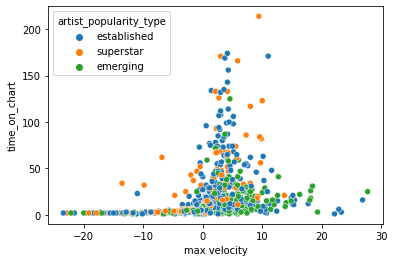

In [99]:

sns.scatterplot( x=spotify2020['max velocity'], y=spotify2020['time_on_chart'], hue=spotify2020['artist_popularity_type'])

In [111]:
spotify2020['max velocity'].median()

1.7857142857142847

In [100]:
spotify2020.loc[spotify2020['artist_popularity_type'] == 'emerging']['max velocity'].median()

3.85714285714286

In [101]:
spotify2020.loc[spotify2020['artist_popularity_type'] == 'emerging']['time_on_chart'].median()

3.0

In [102]:
spotify2020.loc[spotify2020['artist_popularity_type'] == 'established']['max velocity'].median()

1.57142857142857

In [103]:
spotify2020.loc[spotify2020['artist_popularity_type'] == 'established']['time_on_chart'].median()

2.0

In [104]:
spotify2020.loc[spotify2020['artist_popularity_type'] == 'superstar']['max velocity'].median()

0.0

In [105]:
spotify2020.loc[spotify2020['artist_popularity_type'] == 'superstar']['time_on_chart'].median()

4.0

/home/bull/Documents/practice1/test/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='max velocity', ylabel='Density'>

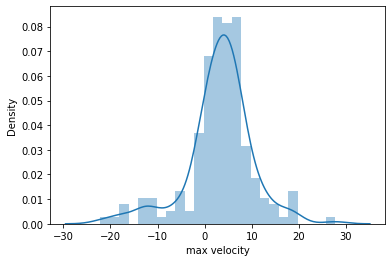

In [107]:
sns.distplot(spotify2020.loc[spotify2020['artist_popularity_type'] == 'emerging']['max velocity'])

/home/bull/Documents/practice1/test/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='velocity', ylabel='Density'>

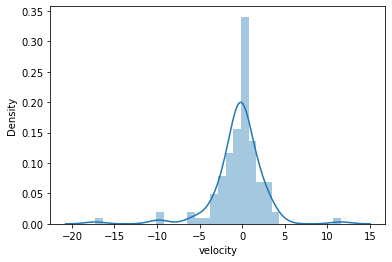

In [24]:
sns.distplot(spotify2020.loc[spotify2020['artist_popularity_type'] == 'established']['max velocity'])

/home/bull/Documents/practice1/test/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='max velocity', ylabel='Density'>

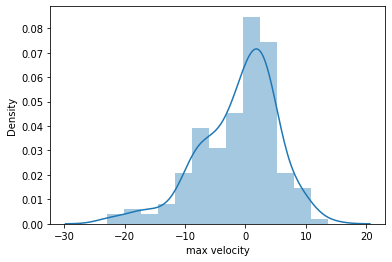

In [108]:
sns.distplot(spotify2020.loc[spotify2020['artist_popularity_type'] == 'superstar']['max velocity'])

### Statistical tests
Null Hypothesis: The Median max velocity for emerging, established, and superstar artists are equal

/home/bull/Documents/practice1/test/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='max velocity', ylabel='Density'>

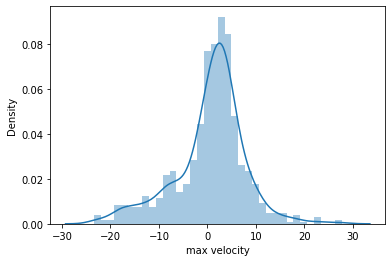

In [114]:
sns.distplot(spotify2020['max velocity'])

In [119]:
#performal normal distribution test
def is_it_normal(array):
    return stats.normaltest(array, nan_policy='omit')

In [120]:
is_it_normal(spotify2020['max velocity'])

NormaltestResult(statistic=58.70752299019757, pvalue=1.7857611052046037e-13)

Because the p-value is extremely small we can reject the null hypothesis that the distribution is normal. So our data is non-parametric. let's use the kruskal wallis test to compare groups

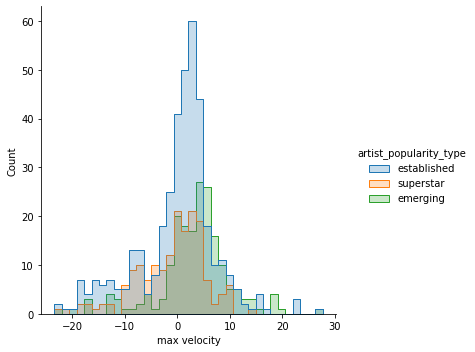

In [145]:
sns.displot(spotify2020, x='max velocity', hue='artist_popularity_type', element='step')

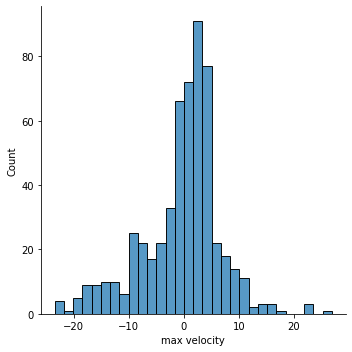

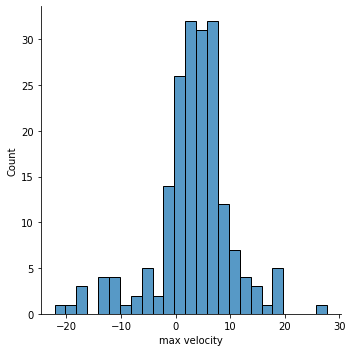

In [151]:
sns.displot(wellknown_maxvelocity)
sns.displot(emerging_maxvelocity)

In [133]:
spotify2020.keys()

Index(['add_date', 'rank', 'title', 'cm_track_id', 'artist_names',
       'cm_artist_ids', 'current_plays', 'time_on_chart', 'velocity',
       'primary_artist', 'secondary_artist', 'primary_artist ID',
       'secondfary_artist ID', 'Prim: Jan. 5-Listeners',
       'Prim: Dec. 6-Listeners', 'artist_popularity_type', 'max velocity'],
      dtype='object')

### Kruskal-Wallis Test

In [147]:
#create array for each group
emerging_maxvelocity = spotify2020.loc[spotify2020['artist_popularity_type'] == 'emerging']['max velocity']
established_maxvelocity = spotify2020.loc[spotify2020['artist_popularity_type'] == 'established']['max velocity']
superstar_maxvelocity = spotify2020.loc[spotify2020['artist_popularity_type'] == 'superstar']['max velocity']
wellknown_maxvelocity = spotify2020.loc[(spotify2020['artist_popularity_type'] == 'superstar') | (spotify2020['artist_popularity_type'] == 'established')]['max velocity']

In [139]:

stats.kruskal(emerging_maxvelocity, established_maxvelocity, superstar_maxvelocity, nan_policy='omit')

KruskalResult(statistic=51.09723780775619, pvalue=8.023720459869356e-12)

In [141]:
def ttest(array1, array2):
    return stats.ttest_ind(array1,array2, nan_policy='omit')

In [142]:
ttest(emerging_maxvelocity, established_maxvelocity)

Ttest_indResult(statistic=4.803666928495043, pvalue=1.9908736055112214e-06)

In [143]:
ttest(emerging_maxvelocity, superstar_maxvelocity)

Ttest_indResult(statistic=6.075814280609885, pvalue=3.13306396541017e-09)

In [144]:
ttest(established_maxvelocity, superstar_maxvelocity)

Ttest_indResult(statistic=1.8252551431615838, pvalue=0.0684998364327843)

## Most Weeks at #1

In [38]:
spotify2020.head()

,add_date,rank,title,cm_track_id,artist_names,cm_artist_ids,current_plays,time_on_chart,velocity,primary_artist,secondary_artist,primary_artist ID,secondfary_artist ID,Prim: Jan. 5-Listeners,Prim: Dec. 6-Listeners,artist_popularity_type
0,2020-01-09T00:00:00.000Z,1,The Box,27599255,['Roddy Ricch'],[839964],18952305,55,0.000000,Roddy Ricch,NaN,839964,NaN,19014642,21923722,established
1,2020-01-09T00:00:00.000Z,2,ROXANNE,27228348,['Arizona Zervas'],[64150],9671478,57,0.000000,Arizona Zervas,NaN,64150,NaN,28519561,12499023,established
2,2020-01-09T00:00:00.000Z,3,Yummy,28077991,['Justin Bieber'],[3479],9648561,6,NaN,Justin Bieber,NaN,3479,NaN,59053556,72539216,superstar
3,2020-01-09T00:00:00.000Z,4,Circles,25021708,['Post Malone'],[135326],8244725,67,-0.142857,Post Malone,NaN,135326,NaN,59360500,41224314,superstar
4,2020-01-09T00:00:00.000Z,5,BOP,25358331,['DaBaby'],[398544],7985170,65,-0.142857,DaBaby,NaN,398544,NaN,21300480,42133931,established


In [40]:
num1tracks = spotify2020.loc[spotify2020['rank'] == 1]

In [43]:
num1tracks['title'].value_counts()

The Box                                      11
ROCKSTAR (feat. Roddy Ricch)                 10
WAP (feat. Megan Thee Stallion)               9
positions                                     4
Toosie Slide                                  3
Blinding Lights                               2
Lemonade (feat. Gunna, Don Toliver & NAV)     2
THE SCOTTS                                    2
cardigan                                      1
Come & Go (with Marshmello)                   1
Therefore I Am                                1
All I Want for Christmas Is You               1
DÁKITI                                        1
Wishing Well                                  1
Name: title, dtype: int64

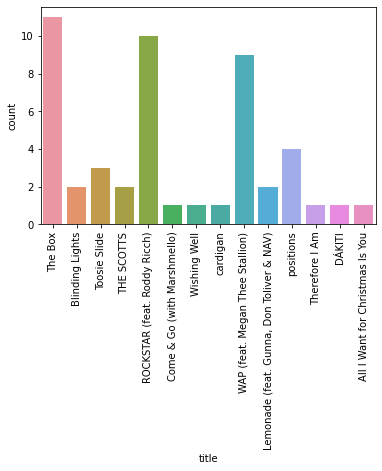

In [52]:
sns.countplot(x=num1tracks['title'])
plt.xticks(rotation=90)
plt.show()

In [ ]:
unique_artist_df

In [ ]:
#look and listener distribution for January 5th

unique_artist_df.describe()

In [ ]:
#new dataframe of 25th percentile of artists - Jan5th
lower25 = unique_artist_df.loc[unique_artist_df['Jan. 5-Listeners'] < unique_artist_df['Jan. 5-Listeners'].quantile(.25)]

In [ ]:
#new feature of listener change between Jan and Dec
lower25['listener_change'] = lower25['Dec. 6-Listeners'] - lower25['Jan. 5-Listeners']

In [ ]:
#new feature of percent change is artist listeners
def percent_change(x):
    return ((x[1]- x[0])/x[0])*100

In [ ]:
lower25['listener percent change %'] = lower25[['Jan. 5-Listeners', 'Dec. 6-Listeners']].apply(lambda x: percent_change(x), axis=1)

In [ ]:
lower25.reset_index(inplace=True, drop=True)

In [ ]:
#find artist with biggest percent gain in listeners

top_emerging_artists = lower25.sort_values('listener percent change %', ascending=False).reset_index(drop=True)

In [ ]:


top_emerging_artists['Jan. 5-Listeners'].apply(lambda x: "{:,}".format(x['Jan. 5-Listeners']))

In [ ]:
#save top emerging artists to csv
top_emerging_artists.to_csv('top_emerging_artists2020.csv', index_label='index')

# top_emerging_artists = pd.read_csv('top_emerging_artists2020.csv', index_col=0)

In [ ]:
listener_sorted = top_emerging_artists.sort_values('listener percent change %', ascending=False)
top5 = listener_sorted.iloc[0:5, :]

In [ ]:
top5.keys()

In [ ]:
sns.barplot(top5['primary_artist'], top5['listener percent change %'], )
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
top5brdg = top5[['title', 'primary_artist', 'Jan. 5-Listeners','Dec. 6-Listeners', 'listener_change', 'listener percent change %']]

In [ ]:
tabulate(top5brdg, headers='keys', tablefmt = 'pretty')

In [ ]:
top5brdg